# Feature Generation

In [1]:
import os
import datetime
import pandas as pd
import numpy as np
from tqdm import tqdm
import joblib

from Alpha_Research import Alpha_Research
from Formulaic_Alpha import *

In [2]:
alpha_dict = dict()
ar = Alpha_Research()

## Accounting Features

In [3]:
features = [ts_change(ar.m['ROA'], 6)]
def operation(x):
    return rank(x[0])
alpha_dict['roa_diff'] = ar.backtest(features, operation)

In [4]:
features = [ts_change(ar.m['OPM'], 3)]
def operation(x):
    return rank(x[0])
alpha_dict['opm_diff'] = ar.backtest(features, operation)

In [5]:
features = [-ts_change(ar.m['SGA'], 3)]
def operation(x):
    return rank(x[0])
alpha_dict['sga_diff'] = ar.backtest(features, operation)

In [6]:
features = [ts_change(ar.m['CFOP'], 25)]
def operation(x):
    return rank(x[0])
alpha_dict['cfop_diff'] = ar.backtest(features, operation)

In [7]:
# sr 0.92
features = [ts_change(ar.m['SG'], 25), ar.m['CAP']]
def operation(x):
    return rank(x[0]/x[1])
alpha_dict['sg_diff'] = ar.backtest(features, operation)

## Market Features

## Alpha Pool Analysis

roa_diff and opm_diff have correlation: 0.48
cfop_diff and sg_diff have correlation: 0.45
opm_diff and sga_diff have correlation: 0.43
roa_diff and sga_diff have correlation: 0.29
roa_diff and cfop_diff have correlation: 0.17
                 2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  \
Min Long Count     68    67    64    65    81    82    88    95    95    92   
Min Short Count    64    58    62    64    75    85    93    91    95    94   

                 2020  2021  2022  2023  
Min Long Count     96    96    94    98  
Min Short Count    90    94    93    93  


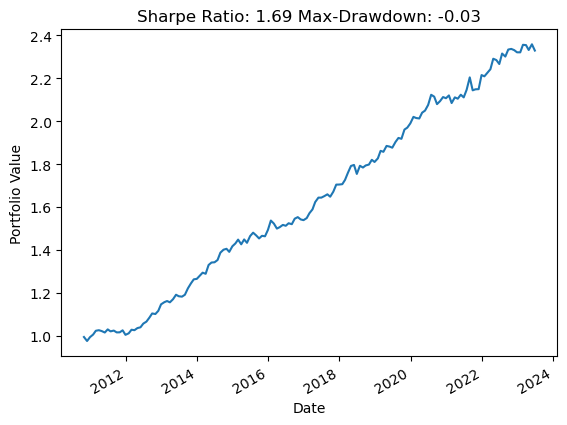

In [8]:
ar.alpha_pool(alpha_dict)

## Extra Time Series Data

In [9]:
market_dict = dict()
# basic
market_dict['ADJC'] = to_monthly(ar.d['ADJC'])

# ts_zscores
for i in [10, 20, 40, 60, 120, 252]:
    market_dict[f'ADJC_Z_{i}'] = to_monthly(ts_zscore(ar.d['ADJC'], 5))
    for j in range(1, 4):
        market_dict[f'ADJC_Z_{i}_{j}'] = market_dict[f'ADJC_Z_{i}'].diff(1)

# return
market_dict['RET10'] = ar.m['RET1W'] / 100
market_dict['RET20'] = ar.m['RET20'] / 100
market_dict['RET40'] = to_monthly(ar.d['ADJC'].pct_change(40))
market_dict['RET60'] = ar.m['RET3M'] / 100
market_dict['RET120'] = ar.m['RET6M'] / 100
market_dict['RET52'] = ar.m['RET1Y'] / 100

# vol
market_dict['VOL5'] = ar.m['VOL5']
market_dict['VOL20'] = ar.m['VOL20']
market_dict['VOL60'] = ar.m['VOL60']
market_dict['VOL120'] = ar.m['VOL120']
market_dict['VOL52'] = ar.m['VOL52']

del market_dict['ADJC'] # non stationary

In [10]:
"""
extras_dict = dict()
for i, v in tqdm(market_dict.items()):
    features = [v]
    def operation(features):
        return rank(features[0])
    extras_dict[i.lower()] = ar.backtest(features, operation)
"""

'\nextras_dict = dict()\nfor i, v in tqdm(market_dict.items()):\n    features = [v]\n    def operation(features):\n        return rank(features[0])\n    extras_dict[i.lower()] = ar.backtest(features, operation)\n'

## Training Data Stacking

In [11]:
stack_list = []
for ticker in tqdm(ar.df_target.columns):
    temp_dict = dict()
    for alpha in list(alpha_dict.keys()):
        try:
            temp_dict[alpha] = alpha_dict[alpha][1][ticker]
        except KeyError:
            pass
    """
    for extra in list(extras_dict.keys()):
        try:
            temp_dict[extra] = extras_dict[extra][1][ticker]
        except KeyError:
            pass
    """
    
    temp_dict['fgsc'] = ar.fgsc[ticker]
    temp_dict['year'] = [i.year for i in list(ar.df_target.index)]
    temp_dict['month'] = [i.month for i in list(ar.df_target.index)]
    temp_dict['target'] = ar.df_target[ticker]

    df_temp = pd.DataFrame(temp_dict)
    df_temp.reset_index(inplace=True)
    df_temp.rename(columns={'index':'Date'}, inplace=True)
    df_temp['Ticker'] = ticker # for index

    df_temp.set_index(['Date', 'Ticker'], inplace=True)
    stack_list.append(df_temp)

100%|███████████████████████████████████████████████████████████████████████████████| 526/526 [00:01<00:00, 350.21it/s]


In [12]:
df_stack = pd.DataFrame()
df_stack = pd.concat(stack_list, axis=0)
df_stack = df_stack[df_stack.iloc[:,:-1].notnull().sum(axis=1)>5]
df_stack = df_stack[~df_stack.iloc[:,-1].isna()]
LB = np.percentile(df_stack.iloc[:,-1], 1)
UB = np.percentile(df_stack.iloc[:,-1], 99)
df_stack['target'] = df_stack['target'].clip(lower=LB, upper=UB)
df_stack.sort_index(inplace=True)
df_stack['fgsc'] = df_stack['fgsc'].astype("category")
new_list = list(df_stack.columns[-5:-1]) + list(df_stack.columns[:-5]) + ['target']
df_stack = df_stack[new_list]

In [13]:
# demean by date and sector
demean_list = []
for dt in tqdm(ar.df_target.index):
    for sc in ar.fgsc.unique():
        temp = df_stack.loc[(dt, slice(None)), :].copy()
        temp = temp[temp['fgsc']==sc]
        temp['target'] = temp['target'].sub(temp['target'].mean())
        demean_list.append(temp)
df_stack = pd.concat(demean_list, axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 153/153 [00:01<00:00, 81.04it/s]


In [14]:
data_path = "data"
stack_name = os.path.join(data_path, "data_stack.h5")
df_stack.to_hdf(stack_name, key='df', mode='w', format="table")